# EE379K Lab 5
## Irfan Hasan (ih3976), Peter Zhang (yz7724)

In [10]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
import seaborn as sns

%matplotlib inline

# Question 1

## Part 1

/Users/irfanhasan/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


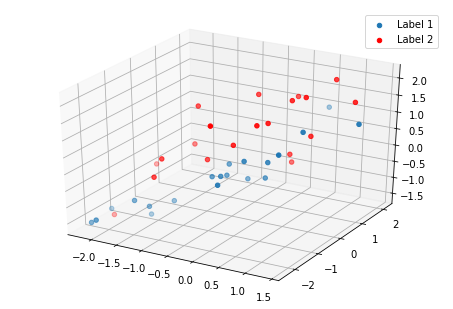

In [18]:
cov1 = [[1, 0.9, 0.9],
        [0.9, 1, 0.9],
        [0.9, 0.9, 1]]
cov2 = [[1, 0.8, 0.8],
        [0.8, 1, 0.8],
        [0.8, 0.8, 1]]
label1 = np.random.multivariate_normal([0, 0, 0], cov1, 20)
label2 = np.random.multivariate_normal([0, 0, 1], cov2, 20)
samples = [label1, label2]


# Plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label1.T[0], label1.T[1], label1.T[2], label='Label 1')
ax.scatter(label2.T[0], label2.T[1], label2.T[2], c='r', label='Label 2')
ax.legend()
fig.show()

## Part 2

within-class Scatter Matrix:
 [[ 36.88543667  31.840454    26.74110955]
 [ 31.840454    38.38901812  26.79287543]
 [ 26.74110955  26.79287543  29.26676422]]
between-class Scatter Matrix:
 [[  1.56468426   1.47671024   5.07379163]
 [  1.47671024   1.39368254   4.78851883]
 [  5.07379163   4.78851883  16.45275158]]

Eigenvector 1: 
[[ 0.32443515]
 [ 0.28388594]
 [-0.90230295]]
Eigenvalue 1: 1.17e+00

Eigenvector 2: 
[[-0.70561893]
 [ 0.70849986]
 [ 0.01139618]]
Eigenvalue 2: -5.74e-17

Eigenvector 3: 
[[ 0.95880217]
 [-0.06979669]
 [-0.27536669]]
Eigenvalue 3: -1.73e-16
Eigenvalues in decreasing order:

1.16929798558
1.72725592676e-16
5.74371110731e-17
Variance explained:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%
Matrix W:
 [ 0.32443515  0.28388594 -0.90230295]


/Users/irfanhasan/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


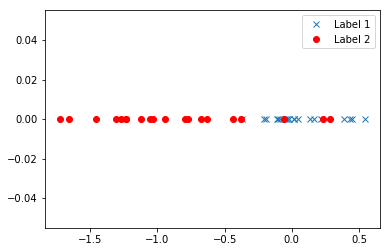

In [40]:
# Compute mean vector
label1_mean = label1.mean(axis=0)
label2_mean = label2.mean(axis=0)

mean_vector = [label1_mean, label2_mean]

# Compute within-class scatter matrix, Sw
n = label1_mean.shape[0] # num of features
Sw = np.zeros((n,n))

for cl,mv in zip(samples, mean_vector):
    class_sc_mat = np.zeros((n,n)) # scatter matrix for every class
    temp = cl - mv
    for row in temp:
        row = row.reshape(n,1) # make column vectors
        class_sc_mat += row.dot((row).T)
    Sw += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', Sw)

# Compute between-class scatter matrix, Sb
all_samples = np.vstack(samples)
# Mean feature vector for combined samples between all classes
overall_mean = all_samples.mean(axis=0).reshape((n, 1))


Sb = np.zeros((n,n))

for cl, mean_vec in zip(samples, mean_vector):
    n1 = cl.shape[0]  #Number of samples within each class
    mean_vec = mean_vec.reshape((n,1)) # make column vector
    t = mean_vec - overall_mean
    Sb += n1 * t @ t.T

print('between-class Scatter Matrix:\n', Sb)

#Solve generalized eigenvalue problem for Sw-1Sb
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(n,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])
    
    
# "Explained variance"
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

# Choose eigenvector with the highest eigenvalue:
W = eig_pairs[0][1]
print('Matrix W:\n', W.real)

# Project data matrix onto new subspace
label1_lda = label1 @ W
label2_lda = label2 @ W



fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(label1_lda, np.zeros(label1_lda.shape[0]), label='Label 1', marker='x', linestyle='')
ax.plot(label2_lda, np.zeros(label2_lda.shape[0]), c='r', label='Label 2', marker='o', linestyle='')
ax.legend()
fig.show()

## Part 3

Custom LDA implementation subspace vector
 [ 0.32443515  0.28388594 -0.90230295]
sklearn LDA subspace vector
 [-1.56174282 -1.36654993  4.3434417 ]
The two LDAs produced results that were very similiar to each other, with the main difference being different scalings
Both separated the two classes well


/Users/irfanhasan/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


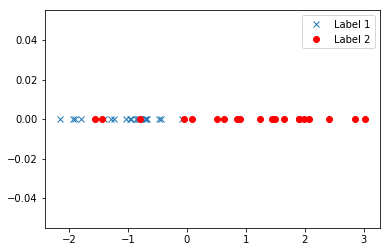

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
n1 = label1.shape[0]
n2 = label2.shape[0]

sk_lda = LDA(n_components=1)
y = np.hstack((np.zeros(n1), np.ones(n2)))
lda = sk_lda.fit_transform(all_samples, y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lda[:n1], np.zeros(label1_lda.shape[0]), label='Label 1', marker='x', linestyle='')
ax.plot(lda[n1:], np.zeros(label2_lda.shape[0]),  c='r', label='Label 2', marker='o', linestyle='')
ax.legend()
fig.show()

W_skl = sk_lda.coef_


print('Custom LDA implementation subspace vector\n', W.real)

print('sklearn LDA subspace vector\n', W_skl.reshape(-1))

print('The two LDAs produced results that were very similiar to each other, with the main difference being different scalings')
print('Both separated the two classes well')

# Question 2

## Part A

In [4]:
weekly = pd.read_csv('weekly.csv')
weekly.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1089.0,545.000000,314.511526,1.000000,273.000000,545.00000,817.000000,1089.000000
Year,1089.0,2000.048669,6.033182,1990.000000,1995.000000,2000.00000,2005.000000,2010.000000
Lag1,1089.0,0.150585,2.357013,-18.195000,-1.154000,0.24100,1.405000,12.026000
Lag2,1089.0,0.151079,2.357254,-18.195000,-1.154000,0.24100,1.409000,12.026000
Lag3,1089.0,0.147205,2.360502,-18.195000,-1.158000,0.24100,1.409000,12.026000
Lag4,1089.0,0.145818,2.360279,-18.195000,-1.158000,0.23800,1.409000,12.026000
Lag5,1089.0,0.139893,2.361285,-18.195000,-1.166000,0.23400,1.405000,12.026000
Volume,1089.0,1.574618,1.686636,0.087465,0.332022,1.00268,2.053727,9.328214
Today,1089.0,0.149899,2.356927,-18.195000,-1.154000,0.24100,1.405000,12.026000


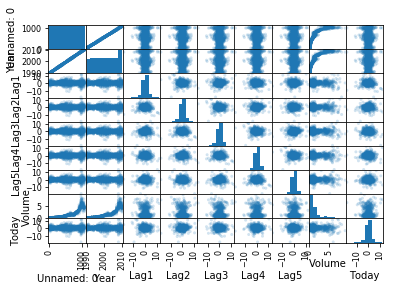

In [5]:
axes = pd.plotting.scatter_matrix(weekly, alpha=0.2)
plt.show()

In [6]:
weekly.corr()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Unnamed: 0,1.000000,0.998863,-0.031577,-0.033129,-0.030420,-0.030935,-0.030382,0.842095,-0.031183
Year,0.998863,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.031577,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033129,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030420,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.030935,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030382,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.842095,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.031183,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


From the above summaries, it appears that volume and year have a relationship. No other patterns are noticable.

## Part B and C

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def trainAndTestClassifier(model, X_train, y_train, X_test, y_true):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    
    confusion = confusion_matrix(y_true, y_pred)
    score = model.score(X_test, y_true)
    
    print('------ Summary for classifier -------')
    print('\nConfusion Matrix: ')
    print(confusion)
    sns.heatmap(confusion)
    print('\nScore: {}'.format(score))

------ Summary for classifier -------

Confusion Matrix: 
[[ 55 429]
 [ 47 558]]

Score: 0.56290174472


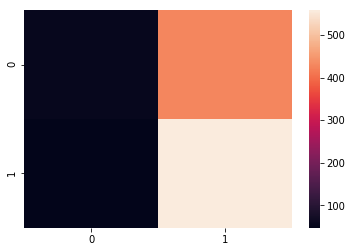

In [11]:
X = weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y = weekly.Direction
log_reg = LogisticRegression()
trainAndTestClassifier(log_reg, X, y, X, y)

From the summary it can be seen that there are a lot of false positives, espicially relative to false negatives. It seems like our regressor is heavily skewed towards the negative class.

## Part D

In [12]:
# Slice through data to create train and test sets and labels
train = weekly[weekly['Year'] < 2009]
test = weekly[weekly['Year'] >= 2009]

X_train = np.matrix(train['Lag2']).T
X_test = np.matrix(test['Lag2']).T
y_train = np.matrix(train['Direction']).T
y_true = np.matrix(test['Direction']).T

------ Summary for classifier -------

Confusion Matrix: 
[[ 9 34]
 [ 5 56]]

Score: 0.625


/Users/peter_zhang/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


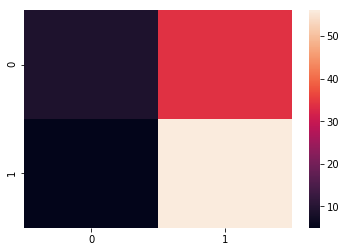

In [13]:
model_log = LogisticRegression()
trainAndTestClassifier(model_log, X_train, y_train, X_test, y_true)

## Part E

------ Summary for classifier -------

Confusion Matrix: 
[[ 9 34]
 [ 5 56]]

Score: 0.625


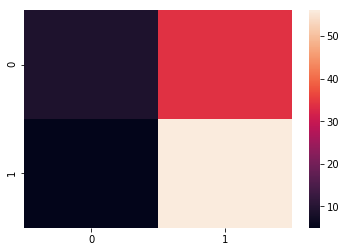

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_lda = LinearDiscriminantAnalysis()
trainAndTestClassifier(model_lda, X_train, y_train, X_test, y_true)

## Part F

------ Summary for classifier -------

Confusion Matrix: 
[[ 0 43]
 [ 0 61]]

Score: 0.586538461538


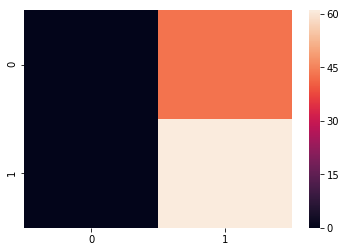

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model_qda = QuadraticDiscriminantAnalysis()
trainAndTestClassifier(model_qda, X_train, y_train, X_test, y_true)

## Part G

------ Summary for classifier -------

Confusion Matrix: 
[[21 22]
 [31 30]]

Score: 0.490384615385


/Users/peter_zhang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


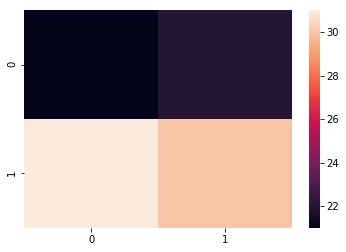

In [16]:
from sklearn.neighbors import KNeighborsClassifier
model_kn = KNeighborsClassifier(n_neighbors=1)
trainAndTestClassifier(model_kn, X_train, y_train, X_test, y_true)

## Part H

Logistic regression and LDA had the same test error rates and were the highest.

# Question 3 (Peter)

## Part 1

In [80]:
# set random seed
np.random.seed()

# read Default csv
default = pd.read_csv('default.csv')
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.62507
1,No,Yes,817.180407,12106.13470
2,No,No,1073.549164,31767.13895
3,No,No,529.250605,35704.49394
4,No,No,785.655883,38463.49588


In [75]:
X = default.loc[:, ['balance', 'income']]
Y = default.loc[:, 'default']

## Part 2

In [63]:
# train the model based on 100n% of the data and return error
def calculate_error(X, Y, n):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=n)
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    result = lr.predict(x_test)
    correct = np.sum(result == y_test)
    l = len(result)
    percent = (l - correct) / float(l)
    print 'With {0}% training data, the validation set error is {1:0.2f}%'.format(100*n, 100*percent)

## Part 3

In [117]:
calculate_error(X, Y, 0.40)
calculate_error(X, Y, 0.60)
calculate_error(X, Y, 0.80)

With 40.0% training data, the validation set error is 3.33%
With 60.0% training data, the validation set error is 3.33%
With 80.0% training data, the validation set error is 3.38%


I ran the prediction multiple times and oberseved that as the amount of training data increases, the errors generally shows a decreasing trend and most are around 3.30%-3.70%.

## Part 4

In [93]:
default['is_student'] = default['student'] == 'Yes'
new_X = default.loc[:, ['balance','income','is_student']]

In [120]:
calculate_error(new_X, Y, 0.40)
calculate_error(new_X, Y, 0.60)
calculate_error(new_X, Y, 0.80)

With 40.0% training data, the validation set error is 3.08%
With 60.0% training data, the validation set error is 3.35%
With 80.0% training data, the validation set error is 3.21%


I ran the prediction a few times and observed that most of the errors is around the range of 3.00%-3.50%, which is  better than just using 'balance' and 'income'; therefore, including 'student' does help make the prediction better.

# Question 4 (Peter)

## Part 1

In [38]:
np.random.seed()
y = np.random.standard_normal((100,))
x = np.random.standard_normal((100,))
y = x - 2*(x**2) + np.random.standard_normal((100,))

n = 100, p = 2 <br>
Y = X - 2 * X^2 + ε

## Part 2

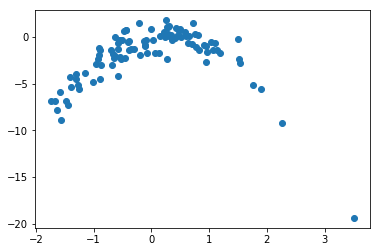

In [4]:
plt.scatter(x, y)
plt.show()

The graph is a upside-down parabola due to squaring the x.

## Part 3

In [43]:
data = pd.DataFrame({'y': list(y), 'x': list(x)}, index=None)
data['x2'] = data['x']**2
data['x3'] = data['x']**3
data['x4'] = data['x']**4

In [32]:
np.random.seed()
lr = LinearRegression()
loo = LeaveOneOut()
Y = data.as_matrix(['y'])

In [36]:
score = cross_val_score(lr, data.as_matrix(['x']), Y, cv=loo, scoring='neg_mean_squared_error').mean()
print '  i. ', score

score = cross_val_score(lr, data[list({'x','x2'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print ' ii. ', score

score = cross_val_score(lr, data[list({'x','x2','x3'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print 'iii. ', score

score = cross_val_score(lr, data[list({'x','x2','x3','x4'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print ' iv. ', score

  i.  -10.4034116678
 ii.  -1.16668518866
iii.  -1.46586294616
 iv.  -2.91037998438


## Part 4

In [37]:
np.random.seed(15)

score = cross_val_score(lr, data.as_matrix(['x']), Y, cv=loo, scoring='neg_mean_squared_error').mean()
print '  i. ', score

score = cross_val_score(lr, data[list({'x','x2'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print ' ii. ', score

score = cross_val_score(lr, data[list({'x','x2','x3'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print 'iii. ', score

score = cross_val_score(lr, data[list({'x','x2','x3','x4'})].values, Y, cv=loo, scoring='neg_mean_squared_error').mean()
print ' iv. ', score

  i.  -10.4034116678
 ii.  -1.16668518866
iii.  -1.46586294616
 iv.  -2.91037998438


The results are the same as in part 3. The reason is because there is no randomness in the training/validation set splits for LOOCV, therefore, the results are the same every time.

## Part 5

X^2 has the smalllest error of -1.167. I expected X^2 to have the smallest value because our data is quadratic and a quadratic would make the best fit. 

## Part 6

In [44]:
import statsmodels.formula.api as smf
results = smf.ols('y ~ x + x2 + x3 + x4', data=data).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     257.0
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           5.00e-50
Time:                        15:19:26   Log-Likelihood:                -136.14
No. Observations:                 100   AIC:                             282.3
Df Residuals:                      95   BIC:                             295.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0641      0.145      0.443      0.6

Both x and x^2 have low p values, which agrees with LOOCV results.